## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Reading the data

In [2]:
housing_data = pd.read_csv("housing_price_dataset.csv")
housing_data.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [3]:
display(housing_data.head())

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


## EDA

In [4]:
display(housing_data.isnull().sum())

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64

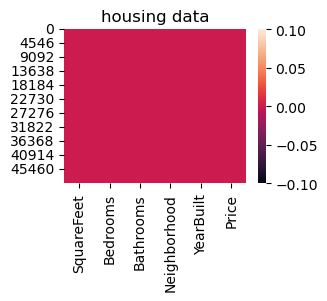

In [5]:
plt.figure(figsize = (10, 2))

plt.subplot(1, 3, 1)
plt.title("housing data")
sns.heatmap(housing_data.isnull())

plt.show()

<Axes: >

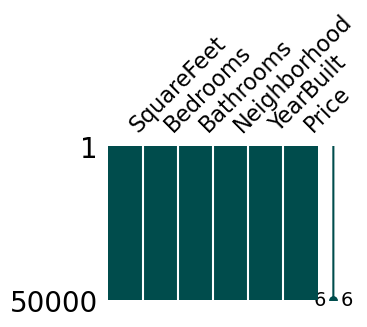

In [6]:
msno.matrix(df=housing_data, figsize=(3,2), color=(0,.3,.3))

In [7]:
display(housing_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


None

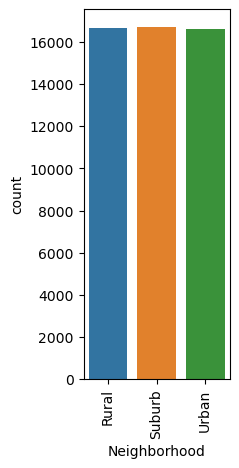

In [8]:
plt.subplot(1, 3, 1)
sns.countplot(x = housing_data["Neighborhood"])
plt.xticks(rotation = 90);

In [9]:
housing_data["Neighborhood"] = housing_data["Neighborhood"].replace({'Rural':1,'Urban':2,'Suburb':3})

In [10]:
display(housing_data)

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,1,1969,215355.283618
1,2459,3,2,1,1980,195014.221626
2,1860,2,1,3,1970,306891.012076
3,2294,2,1,2,1996,206786.787153
4,2130,5,2,3,2001,272436.239065
...,...,...,...,...,...,...
49995,1282,5,3,1,1975,100080.865895
49996,2854,2,2,3,1988,374507.656727
49997,2979,5,3,3,1962,384110.555590
49998,2596,5,2,1,1984,380512.685957


In [11]:
help(housing_data._append)

Help on method _append in module pandas.core.frame:

_append(other, ignore_index: 'bool' = False, verify_integrity: 'bool' = False, sort: 'bool' = False) -> 'DataFrame' method of pandas.core.frame.DataFrame instance



In [12]:
train_feature = housing_data.columns.drop('Price').tolist()
train_feature

['SquareFeet', 'Bedrooms', 'Bathrooms', 'Neighborhood', 'YearBuilt']

In [13]:
housing_data[train_feature].describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='BuPu')\
        .background_gradient(subset=['50%'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
SquareFeet,50000.000000,2006.374680,575.513241,1000.000000,1513.000000,2007.000000,2506.000000,2999.000000
Bedrooms,50000.000000,3.498700,1.116326,2.000000,3.000000,3.000000,4.000000,5.000000
Bathrooms,50000.000000,1.995420,0.815851,1.000000,1.000000,2.000000,3.000000,3.000000
Neighborhood,50000.000000,2.000900,0.817284,1.000000,1.000000,2.000000,3.000000,3.000000
YearBuilt,50000.000000,1985.404420,20.719377,1950.000000,1967.000000,1985.000000,2003.000000,2021.000000


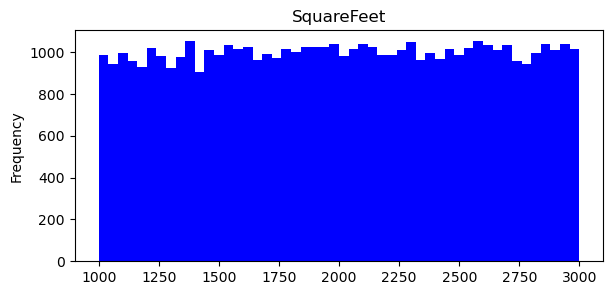

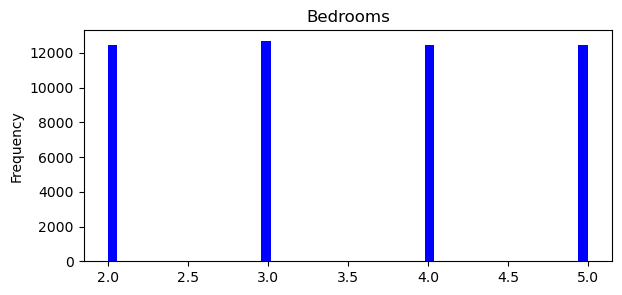

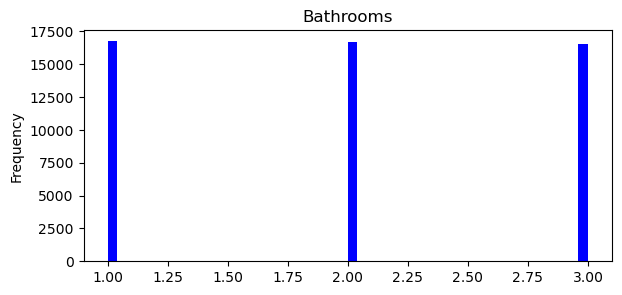

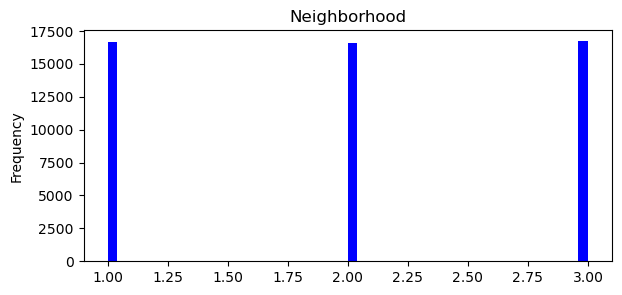

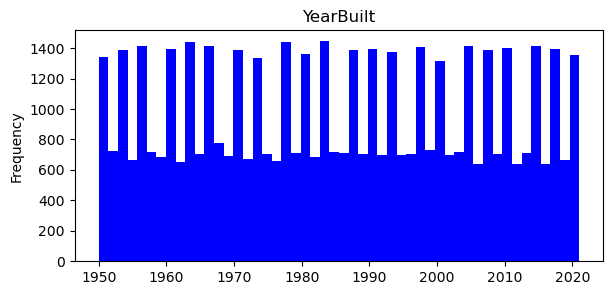

In [14]:
for feat in train_feature:
    plt.figure(figsize=(15,3))
    ax1 = plt.subplot(1,2,1)
    housing_data[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat)
    plt.show()

In [15]:
# Calculate skewness and kurtosis for each column
skewness = housing_data.skew()
kurtosis = housing_data.kurt()

# Printing the results
for column in housing_data.columns[:-1]:
    print(f"Column: {column}")
    print(f"Skewness: {skewness[column]}")
    print(f"Kurtosis: {kurtosis[column]}\n")

Column: SquareFeet
Skewness: -0.011161817099369262
Kurtosis: -1.189925973482508

Column: Bedrooms
Skewness: 0.004640350313677791
Kurtosis: -1.356056808946854

Column: Bathrooms
Skewness: 0.008407664728520576
Kurtosis: -1.497576657664007

Column: Neighborhood
Skewness: -0.001655027801734351
Kurtosis: -1.502886180102843

Column: YearBuilt
Skewness: 0.00555654660638406
Kurtosis: -1.1968387057465915



In [16]:
#Split the dataset into train and test
train, test = train_test_split(housing_data, test_size=0.2, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
display(train.describe())
display(test.describe())

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,2005.959300,3.503100,1.997200,2.000750,1985.390125,224795.672948
std,575.235245,1.115043,0.816002,0.816986,20.687968,76236.358275
min,1000.000000,2.000000,1.000000,1.000000,1950.000000,-36588.165397
25%,1512.000000,3.000000,1.000000,1.000000,1967.000000,169696.292352
50%,2008.000000,4.000000,2.000000,2.000000,1985.000000,225097.074580
75%,2506.000000,4.000000,3.000000,3.000000,2003.000000,279499.666343
max,2999.000000,5.000000,3.000000,3.000000,2021.000000,492195.259972


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2008.036200,3.481100,1.988300,2.001500,1985.461600,224953.933961
std,576.649698,1.121324,0.815248,0.818514,20.845479,75766.268317
min,1000.000000,2.000000,1.000000,1.000000,1950.000000,-18159.685676
25%,1514.000000,2.000000,1.000000,1.000000,1967.000000,171325.969743
50%,2006.000000,3.000000,2.000000,2.000000,1986.000000,224862.129346
75%,2505.000000,4.000000,3.000000,3.000000,2004.000000,279078.673445
max,2999.000000,5.000000,3.000000,3.000000,2021.000000,463977.238482


## Feature Selection

XGBRegressor: 
 [0.8444054  0.05181498 0.03623961 0.03282103 0.03471894]


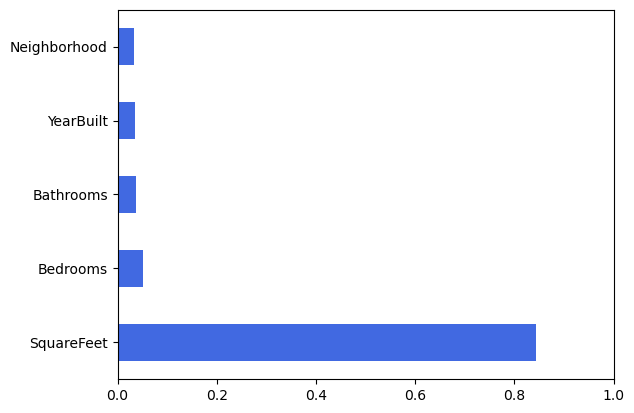

In [17]:
#Feature_Importance_Analysis with XGBRegressor , Prices are highly correlated to SquareFeet.
X_data_feature= train.drop(columns=['Price'],axis=1)
y_data_feature= train['Price']

model = [XGBRegressor()]

model = [model[i].fit(X_data_feature,y_data_feature) for i in range(len(model))]

num_chr = [12, 12, 10]

for i in range(len(model)):
    print(str(model[i])[:num_chr[i]] + ': \n',
          model[i].feature_importances_)
    feat_importances = pd.Series(model[i].feature_importances_,
                                 index=X_data_feature.columns)
    feat_importances.nlargest(10).plot(kind='barh', color='royalblue')
    plt.xlim(0, 1.0)
    plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 5
[LightGBM] [Info] Start training from score 224795.672923
LGBMRegresso: 
 [1400  407  237  184  772]


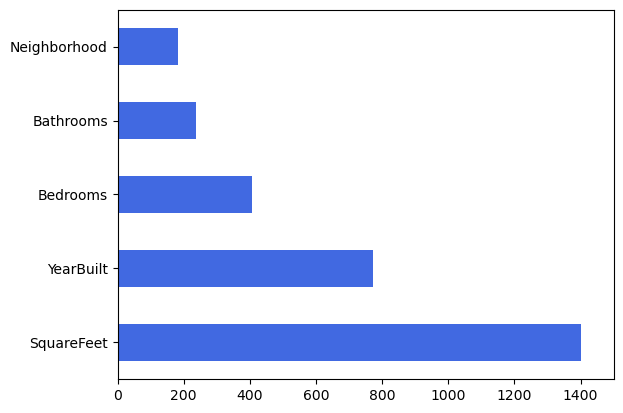

In [18]:
#Feature_Importance_Analysis with LGBMRegressor , Prices also are highly correlated to SquareFeet.
model = [LGBMRegressor()]

model = [model[i].fit(X_data_feature,y_data_feature) for i in range(len(model))]

num_chr = [12, 12, 10]

for i in range(len(model)):
    print(str(model[i])[:num_chr[i]] + ': \n',
          model[i].feature_importances_)
    feat_importances = pd.Series(model[i].feature_importances_,
                                 index=X_data_feature.columns)
    feat_importances.nlargest(10).plot(kind='barh', color='royalblue')
    plt.xlim(0, 1500)
    plt.show()

<catboost.co: 
 [73.39360172  6.87265859  4.31766684  3.66377037 11.75230248]


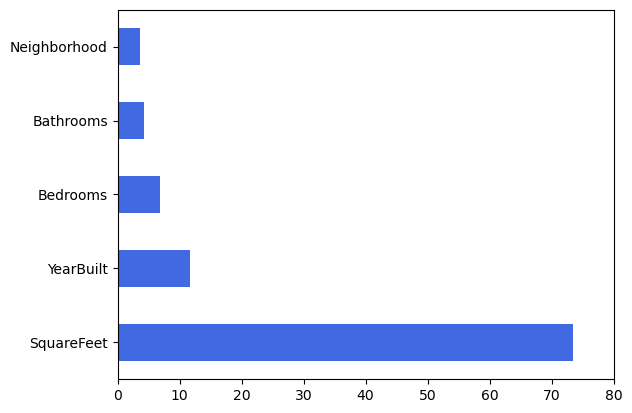

In [19]:
# Feature_Importance_Analysis with CatBoostRegressor , Prices also are highly correlated to SquareFeet.
model = [CatBoostRegressor(logging_level='Silent')]

model = [model[i].fit(X_data_feature,y_data_feature) for i in range(len(model))]

num_chr = [12, 12, 10]

for i in range(len(model)):
    print(str(model[i])[:num_chr[i]] + ': \n',
          model[i].feature_importances_)
    feat_importances = pd.Series(model[i].feature_importances_,
                                 index=X_data_feature.columns)
    feat_importances.nlargest(10).plot(kind='barh', color='royalblue')
    plt.xlim(0, 80)
    plt.show()

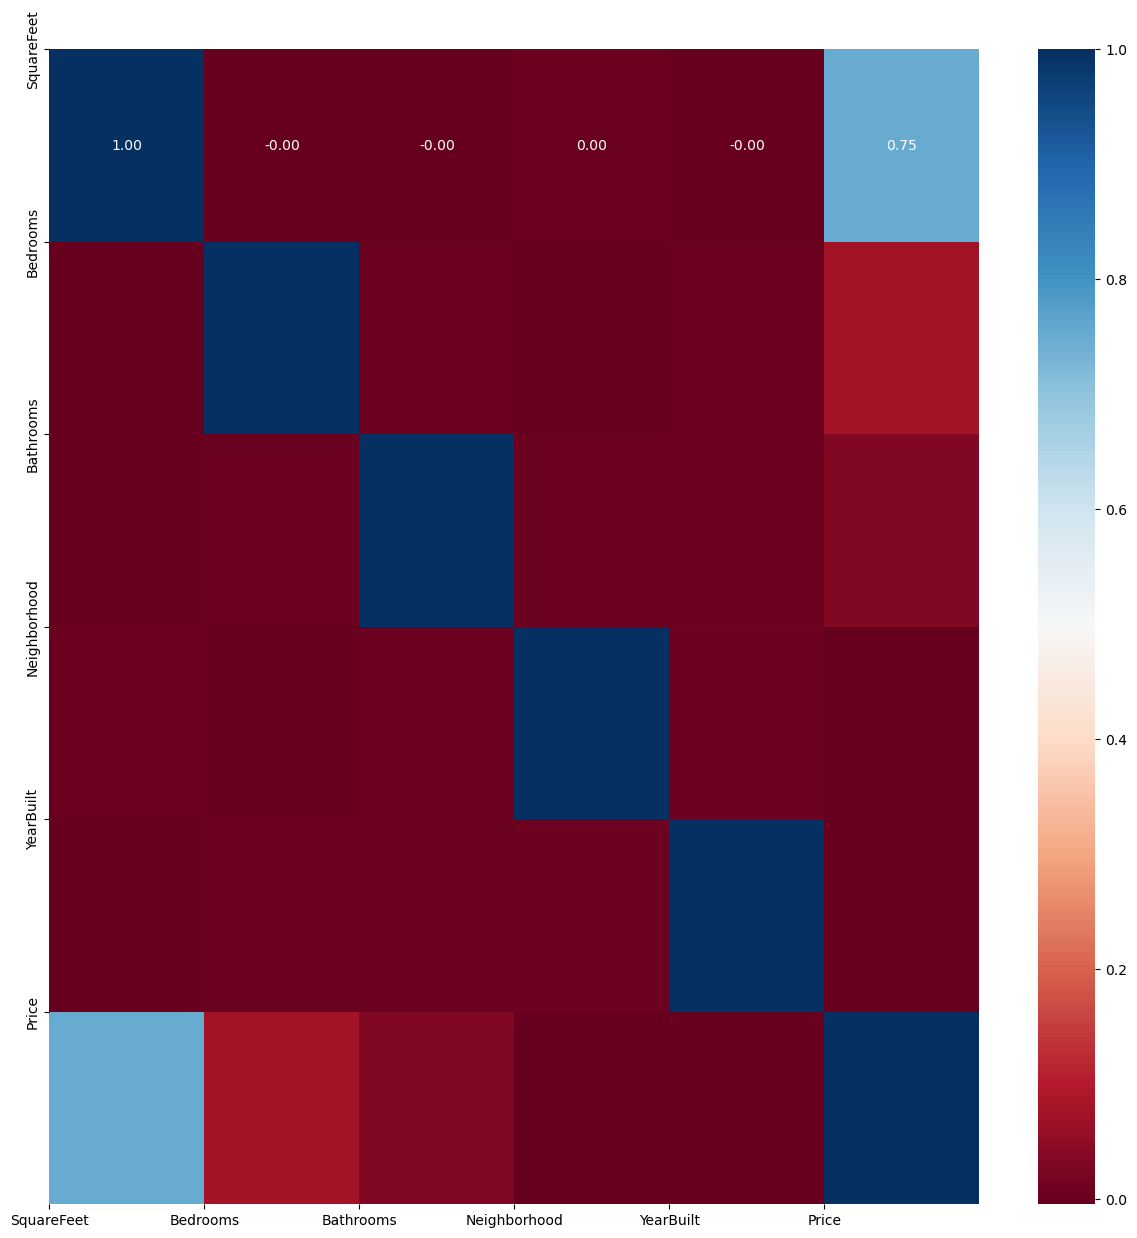

In [20]:
# using Heatmap to find relations between features.
corr = train.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [21]:
# So We need to remove Neighborhood and YearBuilt feature .
X = train.drop(columns=['Price','Neighborhood','YearBuilt'],axis=1)
y = train['Price']

In [22]:
X_train = X
y_train = y

StandardScaler = StandardScaler()
X_train = StandardScaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train

,0,1,2
0,0.855384,-1.348036,1.228934
1,0.650248,1.342476,1.228934
2,0.465973,1.342476,0.003431
3,0.363405,1.342476,-1.222072
4,0.125239,-1.348036,1.228934
...,...,...,...
39995,0.278221,1.342476,1.228934
39996,0.794538,0.445639,-1.222072
39997,1.401254,0.445639,0.003431
39998,0.316467,-0.451199,-1.222072


## Modeling